## Import Necessary Libraries

In [71]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
from collections import Counter
import spacy
from spacy import displacy
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk

## Scrape Data

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

BASE_URL = "https://www.giantbomb.com/games/?game_filter%5Bletter%5D=&game_filter%5BsortBy%5D=&game_filter%5Bplatform%5D=19"
game_data = []

while BASE_URL:
    response = requests.get(BASE_URL)
    soup = BeautifulSoup(response.content, 'html.parser')

    games = soup.find_all('a', href=True)

    for game in games:
        title = game.find('h3', class_='title')
        date = game.find('time', class_='date')
        description = game.find('p', class_='deck')

        if title and date and description:
            game_data.append({
                'Title': title.text.strip(),
                'Release Date': date.text.strip(),
                'Description': description.text.strip()
            })

    next_button = soup.find('a', class_='btn', title="Next page")
    BASE_URL = f"https://www.giantbomb.com{next_button['href']}" if next_button else None

In [38]:
giantbomb = pd.DataFrame(game_data)

In [39]:
giantbomb = giantbomb.dropna(subset=['Description'])
giantbomb['Description'] = giantbomb['Description'].astype(str)

In [40]:
giantbomb['Release Date'] = pd.to_datetime(giantbomb['Release Date'], errors='coerce')
giantbomb = giantbomb.dropna(subset=['Release Date'])
giantbomb['Release Year'] = giantbomb['Release Date'].dt.year

In [41]:
giantbomb = giantbomb.reset_index(drop=True)

## Print and Describe

In [42]:
print(giantbomb.head())

                                           Title Release Date  \
0            The Transformers:Call of the Future   2003-10-30   
1                         Sly 2: Band of Thieves   2004-09-14   
2                      Shadow Man: 2econd Coming   2002-03-02   
3                              Piglet's Big Game   2003-03-19   
4  Dragon Quest VIII: Journey of the Cursed King   2004-11-27   

                                         Description  Release Year  
0         a Japanese game based on the Transformers.          2003  
1  Sly 2: Band of Thieves follows the Cooper Gang...          2004  
2  PlayStation 2 exclusive follow-up to the 1999 ...          2002  
3  A pair of games based on the Disney Winnie the...          2003  
4  The eighth main entry in the Dragon Quest fran...          2004  


In [43]:
print(giantbomb.describe(include='all'))

                         Title                   Release Date Description  \
count                     3184                           3184        3184   
unique                    3176                            NaN        2899   
top     Buzz! Junior: Dino Den                            NaN               
freq                         2                            NaN         273   
mean                       NaN  2004-10-10 17:36:28.944723584         NaN   
min                        NaN            1982-01-01 00:00:00         NaN   
25%                        NaN            2002-12-01 06:00:00         NaN   
50%                        NaN            2004-11-02 00:00:00         NaN   
75%                        NaN            2006-10-06 00:00:00         NaN   
max                        NaN            2013-09-24 00:00:00         NaN   
std                        NaN                            NaN         NaN   

        Release Year  
count    3184.000000  
unique           NaN  
top   

In [44]:
giantbomb.to_csv('giantbomb_games.csv', index=False)

### Text Enrichment with spaCy

For the analyses below, I have followed the Lab 3 material, which was adapted from Web Scraping by Melanie Walsh.

In [45]:
nlp = spacy.load('en_core_web_sm')

In [46]:
#Define example sentence
sentence = "This is 'an' example? sentence"

# Call the nlp model on the sentence
doc = nlp(sentence)

In [47]:
# Define a function that runs the nlp pipeline on any given input text
def process_text(text):
    return nlp(text)

In [48]:
# Apply the function to the "Document" column, so that the nlp pipeline is called on each lecture
giantbomb['Doc'] = giantbomb['Description'].apply(process_text)

### Tokenization

In [49]:
# Define a function to retrieve tokens from a doc object
def get_token(doc):
    return [(token.text) for token in doc]

In [50]:
# Run the token retrieval function on the doc objects in the dataframe
giantbomb['Tokens'] = giantbomb['Doc'].apply(get_token)
giantbomb.head()

,Title,Release Date,Description,Release Year,Doc,Tokens
0,The Transformers:Call of the Future,2003-10-30,a Japanese game based on the Transformers.,2003,"(a, Japanese, game, based, on, the, Transforme...","[a, Japanese, game, based, on, the, Transforme..."
1,Sly 2: Band of Thieves,2004-09-14,Sly 2: Band of Thieves follows the Cooper Gang...,2004,"(Sly, 2, :, Band, of, Thieves, follows, the, C...","[Sly, 2, :, Band, of, Thieves, follows, the, C..."
2,Shadow Man: 2econd Coming,2002-03-02,PlayStation 2 exclusive follow-up to the 1999 ...,2002,"(PlayStation, 2, exclusive, follow, -, up, to,...","[PlayStation, 2, exclusive, follow, -, up, to,..."
3,Piglet's Big Game,2003-03-19,A pair of games based on the Disney Winnie the...,2003,"(A, pair, of, games, based, on, the, Disney, W...","[A, pair, of, games, based, on, the, Disney, W..."
4,Dragon Quest VIII: Journey of the Cursed King,2004-11-27,The eighth main entry in the Dragon Quest fran...,2004,"(The, eighth, main, entry, in, the, Dragon, Qu...","[The, eighth, main, entry, in, the, Dragon, Qu..."


In [51]:
tokens = giantbomb[['Description', 'Tokens']].copy()
tokens.head()

,Description,Tokens
0,a Japanese game based on the Transformers.,"[a, Japanese, game, based, on, the, Transforme..."
1,Sly 2: Band of Thieves follows the Cooper Gang...,"[Sly, 2, :, Band, of, Thieves, follows, the, C..."
2,PlayStation 2 exclusive follow-up to the 1999 ...,"[PlayStation, 2, exclusive, follow, -, up, to,..."
3,A pair of games based on the Disney Winnie the...,"[A, pair, of, games, based, on, the, Disney, W..."
4,The eighth main entry in the Dragon Quest fran...,"[The, eighth, main, entry, in, the, Dragon, Qu..."


### Lemmatization

In [52]:
# Define a function to retrieve lemmas from a doc object
def get_lemma(doc):
    return [(token.lemma_) for token in doc]

# Run the lemma retrieval function on the doc objects in the dataframe
giantbomb['Lemmas'] = giantbomb['Doc'].apply(get_lemma)

In [53]:
print(f'"Game" appears in the text tokens column ' + str(giantbomb['Tokens'].apply(lambda x: x.count('game')).sum()) + ' times.')
print(f'"Game" appears in the lemmas column ' + str(giantbomb['Lemmas'].apply(lambda x: x.count('game')).sum()) + ' times.')

"Game" appears in the text tokens column 1708 times.
"Game" appears in the lemmas column 1928 times.


### Part of Speech Tagging

In [54]:
# Define a function to retrieve lemmas from a doc object
def get_pos(doc):
    #Return the coarse- and fine-grained part of speech text for each token in the doc
    return [(token.pos_, token.tag_) for token in doc]

# Define a function to retrieve parts of speech from a doc object
giantbomb['POS'] = giantbomb['Doc'].apply(get_pos)

In [55]:
# Define function to extract proper nouns from Doc object
def extract_proper_nouns(doc):
    return [token.text for token in doc if token.pos_ == 'PROPN']

# Apply function to Doc column and store resulting proper nouns in new column
giantbomb['Proper_Nouns'] = giantbomb['Doc'].apply(extract_proper_nouns)

In [56]:
list(giantbomb.loc[[5, 10], 'Proper_Nouns'])

[['Garfield'], ['Jade', 'Hillys']]

### Named Entity Recognition

In [57]:
# Define function to extract named entities from doc objects
def extract_named_entities(doc):
    return [ent.label_ for ent in doc.ents]

# Apply function to Doc column and store resulting named entities in new column
giantbomb['Named_Entities'] = giantbomb['Doc'].apply(extract_named_entities)
giantbomb['Named_Entities']

0                             [NORP]
1          [CARDINAL, FAC, ORG, FAC]
2                    [PRODUCT, DATE]
3                    [ORG, ORG, ORG]
4       [ORDINAL, ORG, ORDINAL, ORG]
                    ...             
3179                              []
3180                              []
3181                              []
3182            [NORP, ORG, ORDINAL]
3183                              []
Name: Named_Entities, Length: 3184, dtype: object

In [58]:
# Define function to extract text tagged with named entities from doc objects
def extract_named_entities(doc):
    return [ent for ent in doc.ents]

# Apply function to Doc column and store resulting text in new column
giantbomb['NE_Words'] = giantbomb['Doc'].apply(extract_named_entities)
giantbomb['NE_Words']

0                                            [(Japanese)]
1       [(2), (the, Cooper, Gang), (Clockwerk), (the, ...
2                              [(PlayStation, 2), (1999)]
3               [(the, Disney, Winnie), (Pooh), (Piglet)]
4       [(eighth), (Dragon, Quest), (first), (Dragon, ...
                              ...                        
3179                                                   []
3180                                                   []
3181                                                   []
3182                       [(Korean), (Hyundai), (first)]
3183                                                   []
Name: NE_Words, Length: 3184, dtype: object

In [90]:
# Extract the first Doc object
doc = giantbomb['Doc'][1]

# Visualize named entity tagging in a single paper
displacy.render(doc, style='ent', jupyter=True)

### Additional Steps for Data Exploration

### Text Cleaning

In [73]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

all_text = " ".join(giantbomb['Description'])
clean_text = re.sub(r'[^\w\s]', '', all_text).lower()

all_words = [word for word in clean_text.split() if word not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ecede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Release Trends by Years

The peaks match with the release date and peak years of the console. We can observe that 2006 was the busiest year for releases.<br>
The PlayStation 2 has one of the longest continuation dates for a console (March 4, 2000 - January 4, 2013).<br>
Earlier years than 2000 may indicate game compilations or remastered editions or re-releases of games released in earler dates. Nostalgia-driven marketing is still common to this day. Super Mario All-Stars for example is a compilation of all games re-released.

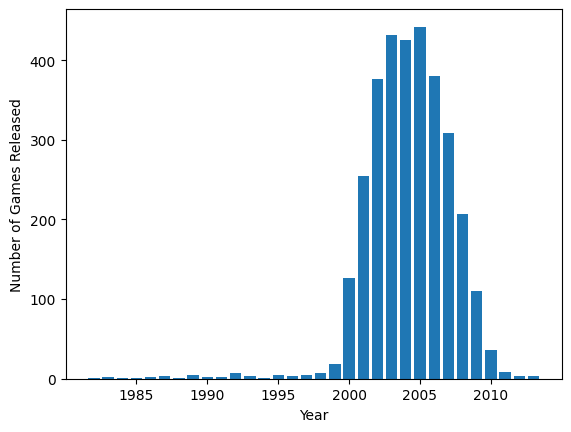

In [74]:
yearly_counts = giantbomb['Release Year'].value_counts().sort_index()

plt.bar(yearly_counts.index, yearly_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.show()

### 2. A Wordcloud

Followed this tutorial: https://thecleverprogrammer.com/2021/11/11/word-cloud-from-a-pandas-dataframe-in-python/
<br>
We can observe the diversity of game genres seen in the wordcloud, like "adventure", "racing", "battle", and "visual novel". <br>
We can also see some features of games such as "third person", turn based".<br>
Sony is a Japanese corporation therefore we see "Japan" and "Japanese" appearing so slightly larger than some words here as well. <br>
It also explains, some words mainly popular in Japan and mainly for Japanese audience: "pachislot", "anime", "manga".

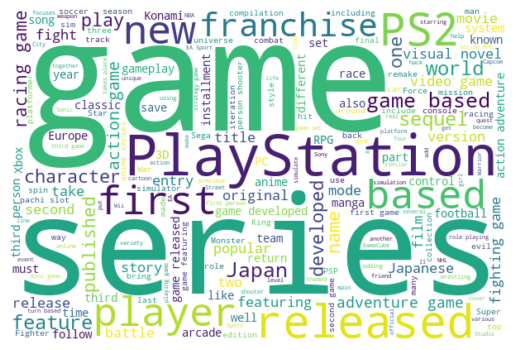

In [87]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white", height=400, width=600).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. Top Organizations (Companies or Brands in this case)

By the presence of 'Capcom', 'Sony', 'Namco' and 'EA', 'Konami': We can observe the major game publishers and developers, (except Electronic Arts they are all Japan-based companies)<br>
'NBA', 'NHL', and 'NCAA' all indicate sports-related games are in abundancy.<br>
'PSP' and 'the PlayStation 2' are Sony's platforms which the dataset is about. Their popularity dates overlap therefore the games mentioned were present in both platforms.

In [89]:
organizations = []
for entities in giantbomb['NE_Words']:
    for ent in entities:
        if ent.label_ == 'ORG':
            organizations.append(ent.text)

organization_counts = Counter(organizations)

top_organizations = organization_counts.most_common(15)

print(top_organizations)


[('RPG', 61), ('PSP', 40), ('NBA', 30), ('Capcom', 26), ('Sony', 26), ('EA', 24), ('NCAA', 23), ('NHL', 22), ('the PlayStation 2', 22), ('SingStar', 18), ('MLB', 17), ('Namco', 15), ('NFL', 15), ('EA Sports', 14), ('the Playstation 2', 14)]
